In [1]:
# Declare paths to data
DATA_PATH =\
    '../../data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv'
# Note that these files are based on using the PPCA model
# of Wang and Blei (2018). W represents global factor
# coefficients and Z represents latent factor loadings
PATH_TO_W_PARAMS = '../../data/processed/W_inferred_PPCA.csv'
PATH_TO_Z_PARAMS = '../../data/processed/Z_inferred_PPCA.csv'

# Note the columns of interest for this notebook
MODE_ID_COLUMN = 'mode_id'
OBS_ID_COLUMN = 'observation_id'

TIME_COLUMN = 'total_travel_time'
COST_COLUMN = 'total_travel_cost'
DISTANCE_COLUMN = 'total_travel_distance'
LICENSE_COLUMN = 'num_licensed_drivers'
NUM_AUTOS_COLUMN = 'num_cars'

UTILITY_COLUMNS =\
    [TIME_COLUMN,
     COST_COLUMN,
     DISTANCE_COLUMN,
     LICENSE_COLUMN,
     NUM_AUTOS_COLUMN]

# Note the travel mode of intersest for this notebook
DRIVE_ALONE_ID = 1

# Note the number of permutations to be used when
# testing the causal graphs
NUM_PERMUTATIONS = 100

# Choose a color to represent reference /
# permutation-based test statistics
PERMUTED_COLOR = '#a6bddb'

In [2]:
# Built-in modules
import sys
import itertools
from typing import Optional, Tuple

# Third party modules
import numpy as np
import pandas as pd
import scipy.stats

# Local modules
sys.path.insert(0, '../../')
import src.viz.sim_cdf as sim_cdf
import src.testing.observable_independence as oi
import src.testing.latent_independence as li

from src.graphs.drive_alone_utility import (DRIVE_ALONE_UTILITY)
from src.utils import sample_from_factor_model

In [3]:
# Load the raw data
df = pd.read_csv(DATA_PATH)

# Look at the data being used in this notebook
print(df.loc[df[MODE_ID_COLUMN] == DRIVE_ALONE_ID,
             UTILITY_COLUMNS + [OBS_ID_COLUMN]]
        .head(5)
        .T)

# Create a dataframe with the variables posited
# to make up the drive-alone utility
drive_alone_df =\
    df.loc[df[MODE_ID_COLUMN] == DRIVE_ALONE_ID,
           UTILITY_COLUMNS]

# Figure out how many observations we have with
# the drive alone mode being available
num_drive_alone_obs = drive_alone_df.shape[0]


                           0        8        16       24       32
total_travel_time      54.010  39.7800  22.2200  22.3000  47.9500
total_travel_cost       5.714   4.4519   1.6817   1.6817   5.9782
total_travel_distance  30.920  24.0900   9.1000   9.1000  32.3500
num_licensed_drivers    2.000   2.0000   2.0000   2.0000   2.0000
num_cars                2.000   2.0000   2.0000   2.0000   2.0000
observation_id          1.000   2.0000   3.0000   4.0000   5.0000


# PC Algorithm

## Step 1: construct the fully connected graph

## Step 2 : Test all "0-order interactions," i.e., marginal independencies

100%|██████████| 100/100 [00:00<00:00, 953.28it/s]

total_travel_time vs total_travel_cost:
The p-value of the permutation C.I.T. is 0.00.


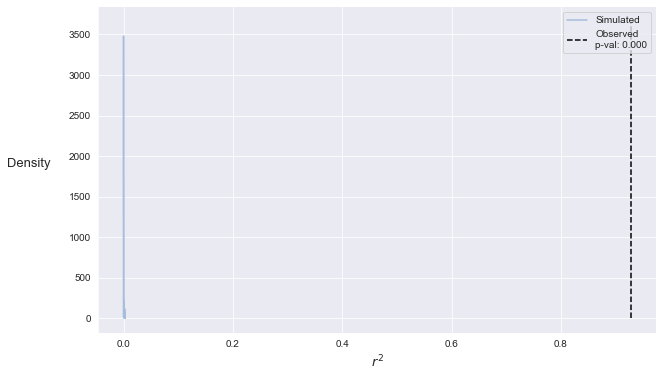

100%|██████████| 100/100 [00:00<00:00, 895.62it/s]

total_travel_time vs total_travel_distance:
The p-value of the permutation C.I.T. is 0.00.


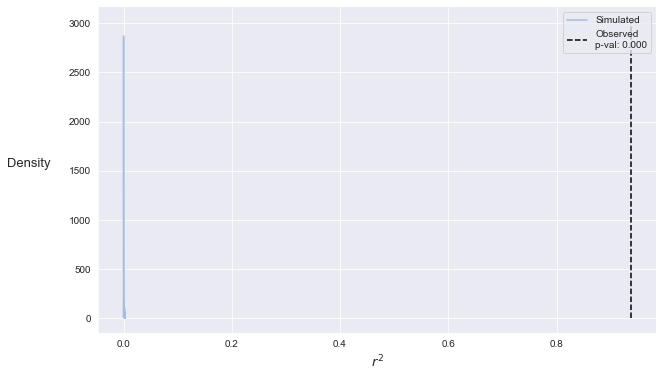

100%|██████████| 100/100 [00:00<00:00, 1015.72it/s]

total_travel_time vs num_licensed_drivers:
The p-value of the permutation C.I.T. is 0.31.


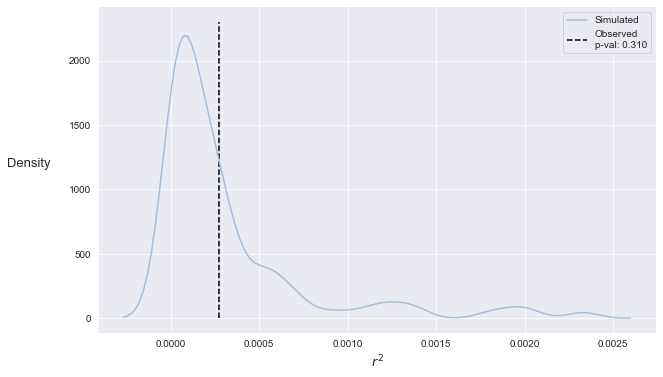

100%|██████████| 100/100 [00:00<00:00, 884.20it/s]

total_travel_time vs num_cars:
The p-value of the permutation C.I.T. is 0.01.


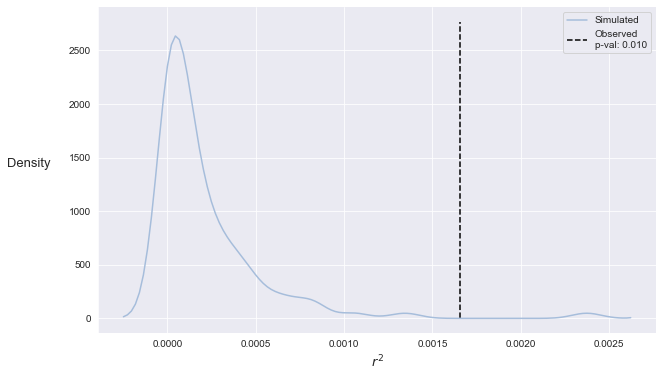

100%|██████████| 100/100 [00:00<00:00, 1101.71it/s]

total_travel_cost vs total_travel_distance:
The p-value of the permutation C.I.T. is 0.00.


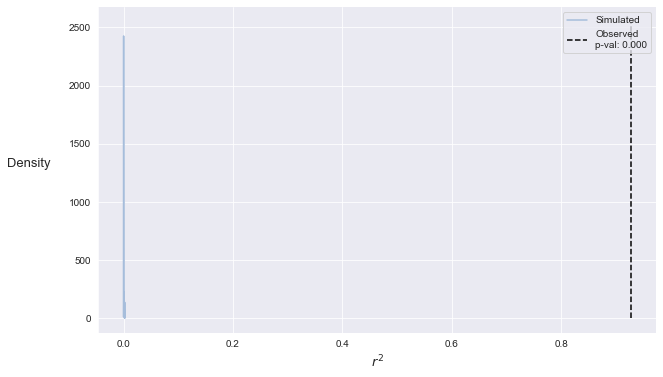

100%|██████████| 100/100 [00:00<00:00, 1046.89it/s]

total_travel_cost vs num_licensed_drivers:
The p-value of the permutation C.I.T. is 0.32.


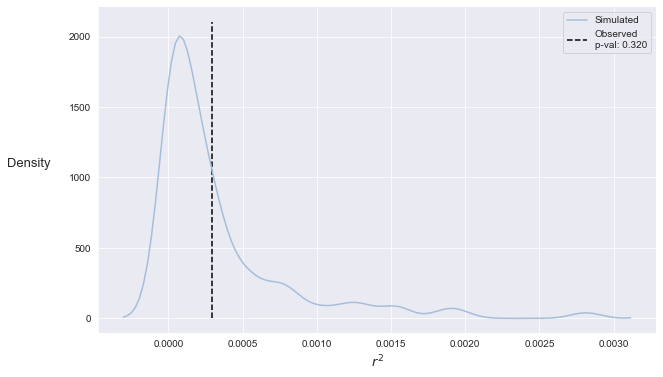

100%|██████████| 100/100 [00:00<00:00, 1002.22it/s]

total_travel_cost vs num_cars:
The p-value of the permutation C.I.T. is 0.00.


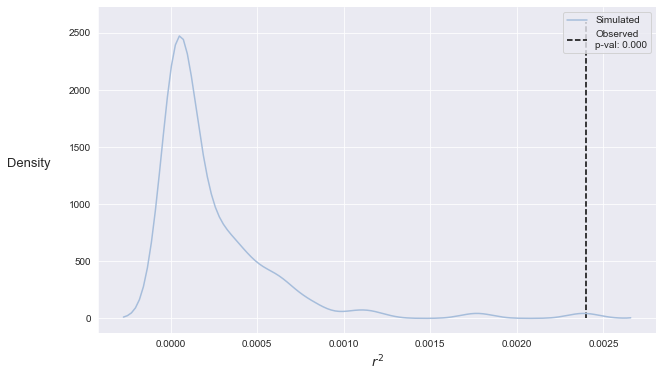

100%|██████████| 100/100 [00:00<00:00, 1082.90it/s]

total_travel_distance vs num_licensed_drivers:
The p-value of the permutation C.I.T. is 0.91.


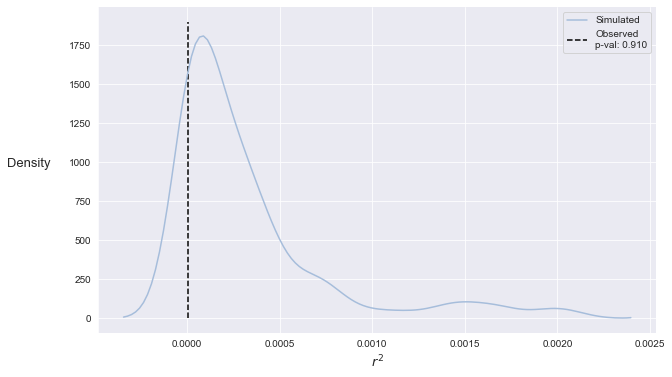

100%|██████████| 100/100 [00:00<00:00, 1140.71it/s]

total_travel_distance vs num_cars:
The p-value of the permutation C.I.T. is 0.00.


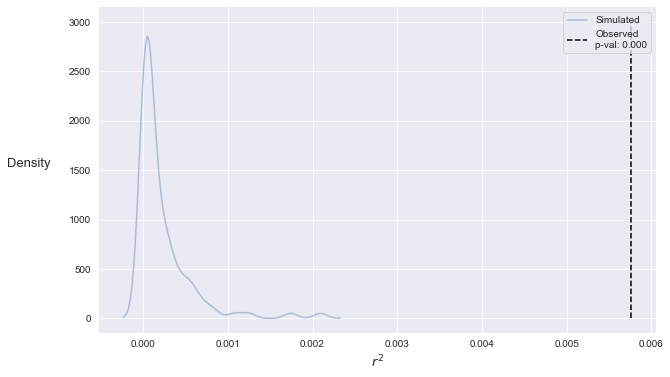

100%|██████████| 100/100 [00:00<00:00, 1039.39it/s]

num_licensed_drivers vs num_cars:
The p-value of the permutation C.I.T. is 0.00.


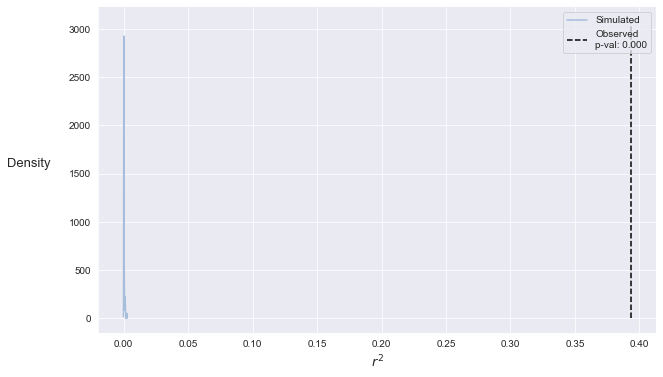

In [4]:
# Get all pairs of variables
col_pairs = list(itertools.combinations(UTILITY_COLUMNS, 2))

# Set a seed for reproducbility
np.random.seed(938)

# Test the marginal independencies of all pairs of variables
for col_1, col_2 in col_pairs:
    col_1_array = drive_alone_df[col_1].values
    col_2_array = drive_alone_df[col_2].values
    
    print('{} vs {}:'.format(col_1, col_2))
    oi.visual_permutation_test(
        col_1_array,
        col_2_array,
        z_array=None,
        num_permutations=NUM_PERMUTATIONS,
        permutation_color=PERMUTED_COLOR)

From the results above, the joint distributions of the following variable pairs merit further investigation for marginal independence:
- total_travel_distance vs num_licensed_drivers
- total_travel_cost vs num_licensed_drivers
- total_travel_time vs num_licensed_drivers

I should take the following investigatory actions:
1. Look at the data, i.e., the bivariate plots of the pairs of variables.
2. Examine the data summaries, i.e. the models, being used for under-fitting and sensibility (e.g. should this be a linear regression at all?).
3. Check whether the suggested independencies (alone and as a collection) make sense logically.
4. Try a predictive independence test based on predicting the variance of the conditional distributions instead of predicting the mean.

For now though, I'm going to keep going tonight (June 15th, 2020) in an attempt to learn as many new things as possible, instead of doing the most thorough job I can on each substep.
I will come back to the actions listed above.

## Step 3: Update the working graph

In [5]:
# Remove the edges given by the pairs of variables that passed the conditional independence tests.

## Step 4: Test for all "1st-order" interactions, i.e., conditional independences

In [6]:
triplets = list(itertools.permutations(UTILITY_COLUMNS, 3))

100%|██████████| 100/100 [00:00<00:00, 909.69it/s]

total_travel_time indep total_travel_cost given total_travel_distance:
The p-value of the permutation C.I.T. is 0.00.


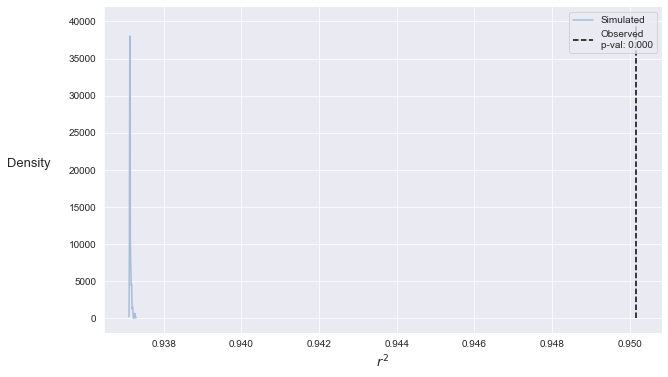

100%|██████████| 100/100 [00:00<00:00, 928.12it/s]

total_travel_time indep total_travel_cost given num_licensed_drivers:
The p-value of the permutation C.I.T. is 0.00.


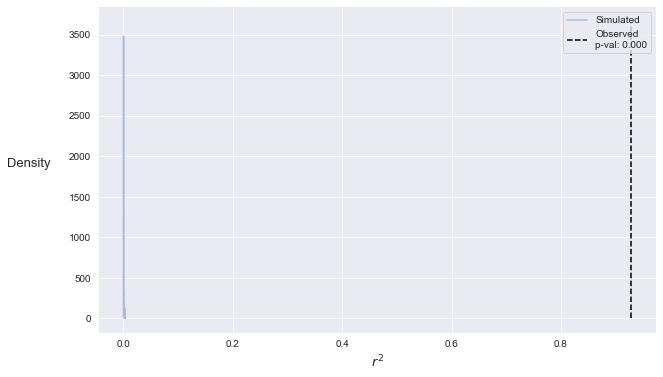

100%|██████████| 100/100 [00:00<00:00, 834.55it/s]

total_travel_time indep total_travel_cost given num_cars:
The p-value of the permutation C.I.T. is 0.00.


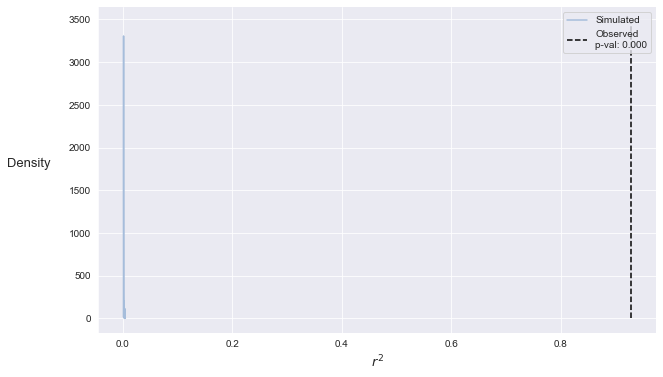

100%|██████████| 100/100 [00:00<00:00, 729.62it/s]

total_travel_time indep total_travel_distance given total_travel_cost:
The p-value of the permutation C.I.T. is 0.00.


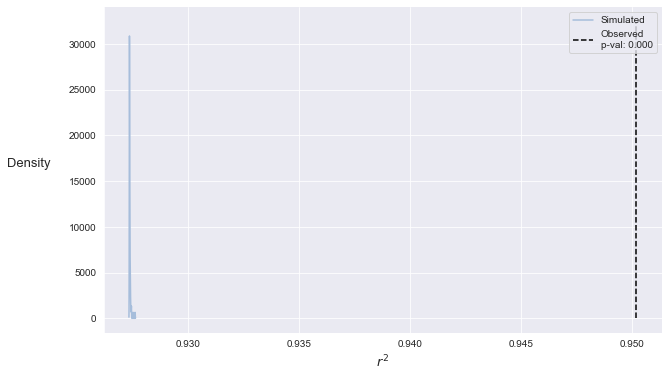

100%|██████████| 100/100 [00:00<00:00, 931.84it/s]

total_travel_time indep total_travel_distance given num_licensed_drivers:


The p-value of the permutation C.I.T. is 0.00.


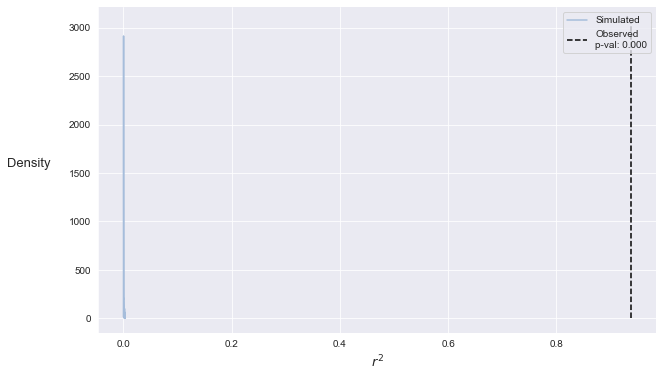

100%|██████████| 100/100 [00:00<00:00, 914.94it/s]

total_travel_time indep total_travel_distance given num_cars:
The p-value of the permutation C.I.T. is 0.00.


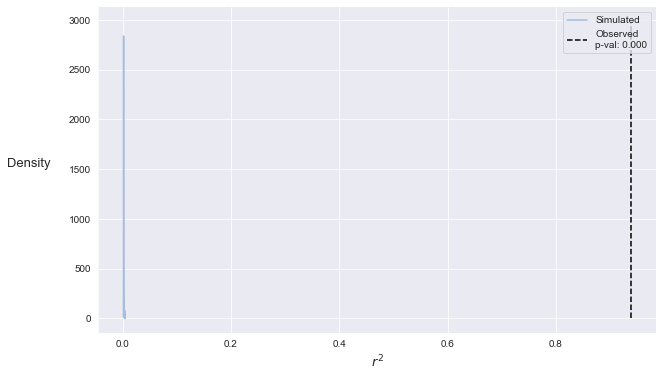

100%|██████████| 100/100 [00:00<00:00, 924.53it/s]

total_travel_time indep num_licensed_drivers given total_travel_cost:
The p-value of the permutation C.I.T. is 0.94.


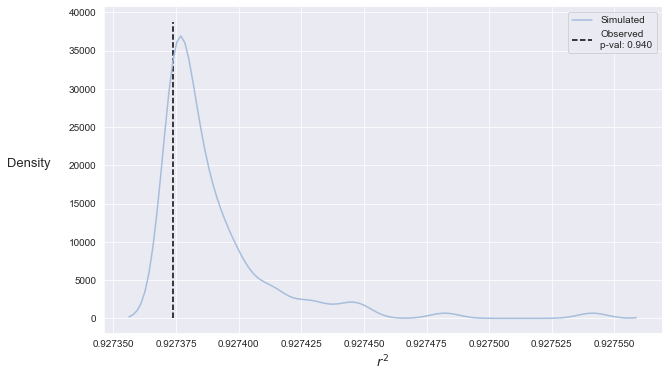

100%|██████████| 100/100 [00:00<00:00, 908.36it/s]

total_travel_time indep num_licensed_drivers given total_travel_distance:
The p-value of the permutation C.I.T. is 0.00.


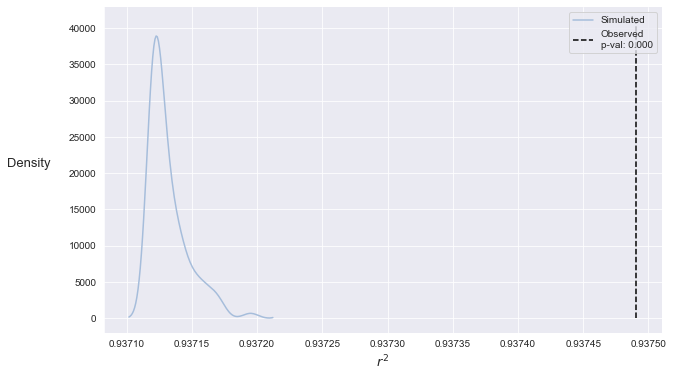

100%|██████████| 100/100 [00:00<00:00, 936.18it/s]

total_travel_time indep num_licensed_drivers given num_cars:
The p-value of the permutation C.I.T. is 0.00.


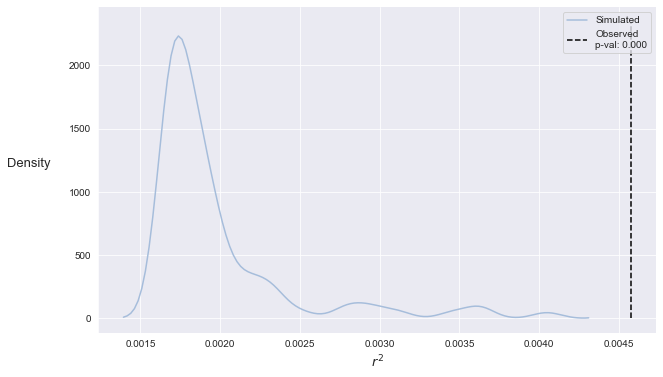

100%|██████████| 100/100 [00:00<00:00, 940.15it/s]

total_travel_time indep num_cars given total_travel_cost:
The p-value of the permutation C.I.T. is 0.13.


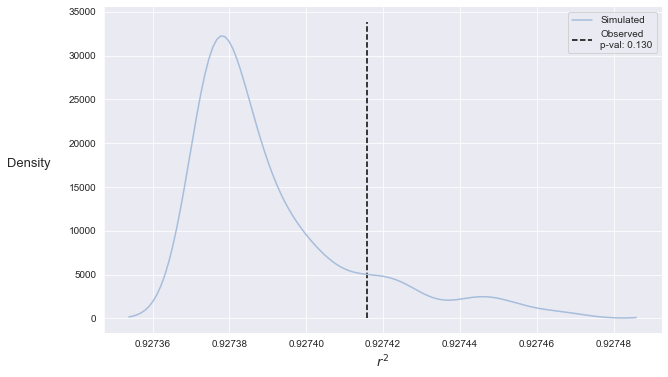

100%|██████████| 100/100 [00:00<00:00, 884.66it/s]

total_travel_time indep num_cars given total_travel_distance:
The p-value of the permutation C.I.T. is 0.00.


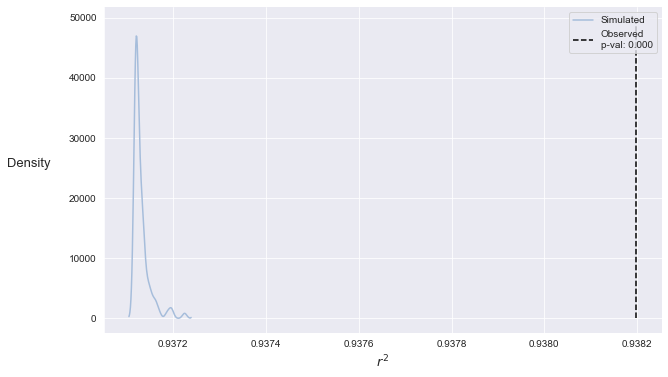

100%|██████████| 100/100 [00:00<00:00, 905.26it/s]

total_travel_time indep num_cars given num_licensed_drivers:
The p-value of the permutation C.I.T. is 0.00.


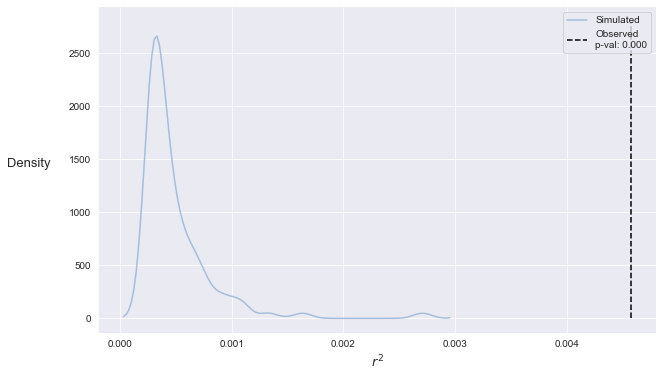

100%|██████████| 100/100 [00:00<00:00, 839.26it/s]

total_travel_cost indep total_travel_time given total_travel_distance:
The p-value of the permutation C.I.T. is 0.00.


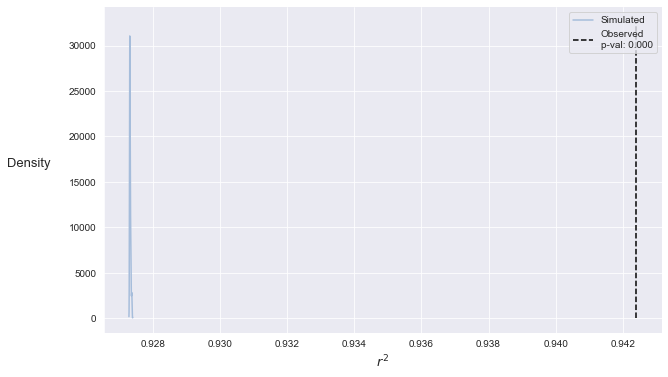

100%|██████████| 100/100 [00:00<00:00, 951.24it/s]

total_travel_cost indep total_travel_time given num_licensed_drivers:
The p-value of the permutation C.I.T. is 0.00.


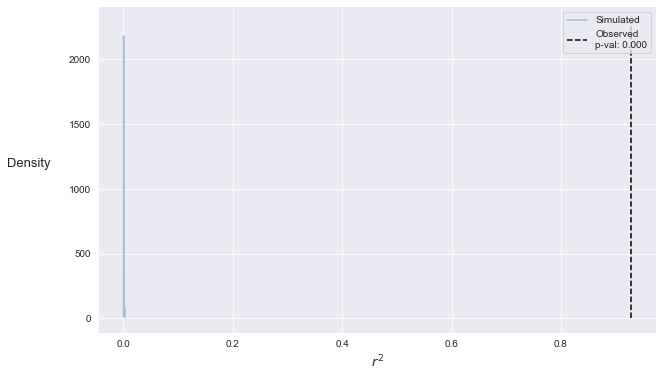

100%|██████████| 100/100 [00:00<00:00, 960.74it/s]

total_travel_cost indep total_travel_time given num_cars:
The p-value of the permutation C.I.T. is 0.00.


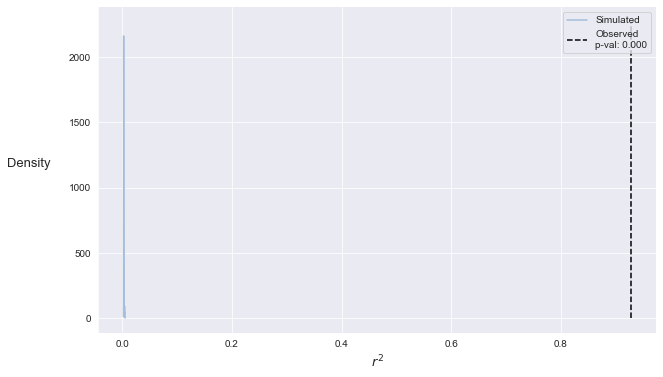

100%|██████████| 100/100 [00:00<00:00, 929.54it/s]

total_travel_cost indep total_travel_distance given total_travel_time:
The p-value of the permutation C.I.T. is 0.00.


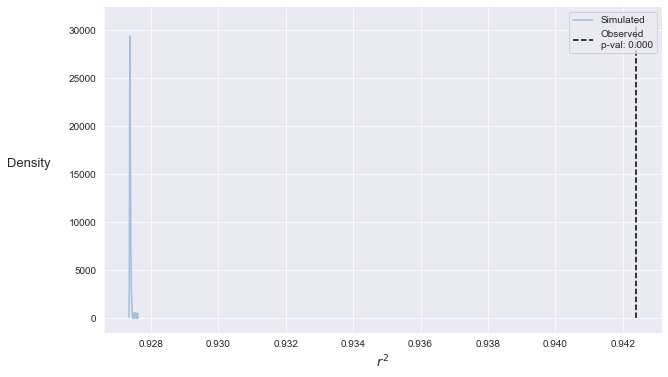

100%|██████████| 100/100 [00:00<00:00, 892.35it/s]

total_travel_cost indep total_travel_distance given num_licensed_drivers:
The p-value of the permutation C.I.T. is 0.00.


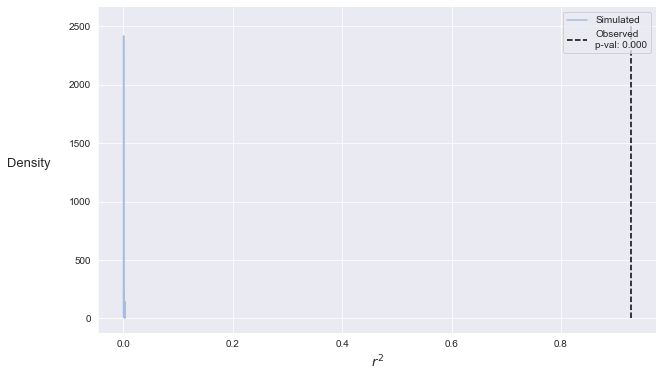

100%|██████████| 100/100 [00:00<00:00, 916.24it/s]

total_travel_cost indep total_travel_distance given num_cars:
The p-value of the permutation C.I.T. is 0.00.


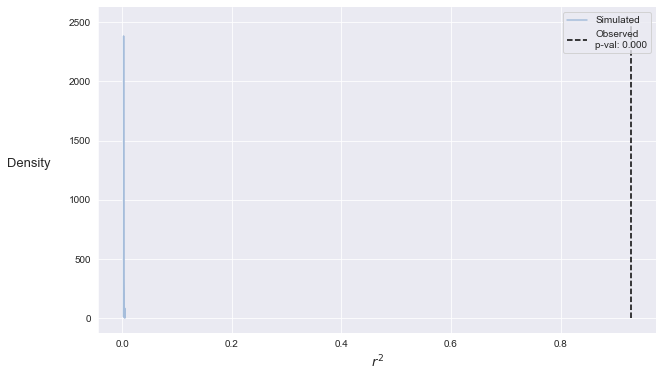

100%|██████████| 100/100 [00:00<00:00, 922.61it/s]

total_travel_cost indep num_licensed_drivers given total_travel_time:
The p-value of the permutation C.I.T. is 0.75.


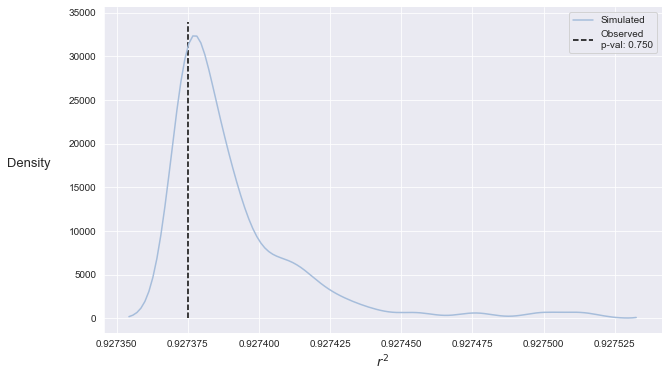

100%|██████████| 100/100 [00:00<00:00, 922.71it/s]

total_travel_cost indep num_licensed_drivers given total_travel_distance:
The p-value of the permutation C.I.T. is 0.00.


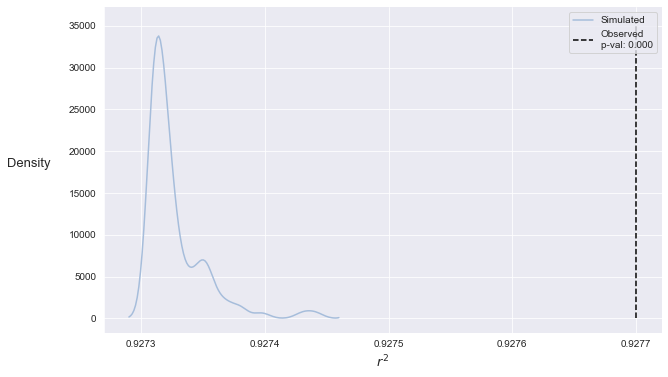

100%|██████████| 100/100 [00:00<00:00, 931.30it/s]

total_travel_cost indep num_licensed_drivers given num_cars:
The p-value of the permutation C.I.T. is 0.00.


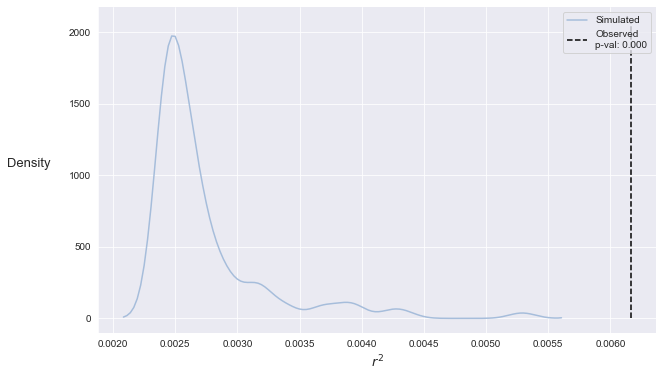

100%|██████████| 100/100 [00:00<00:00, 893.97it/s]

total_travel_cost indep num_cars given total_travel_time:
The p-value of the permutation C.I.T. is 0.02.


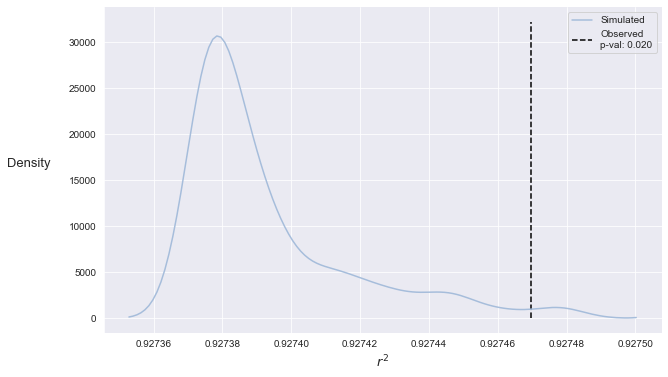

100%|██████████| 100/100 [00:00<00:00, 954.50it/s]

total_travel_cost indep num_cars given total_travel_distance:
The p-value of the permutation C.I.T. is 0.00.


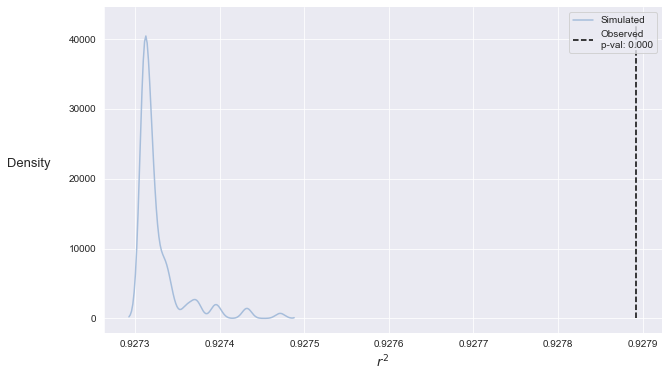

100%|██████████| 100/100 [00:00<00:00, 891.12it/s]

total_travel_cost indep num_cars given num_licensed_drivers:
The p-value of the permutation C.I.T. is 0.00.


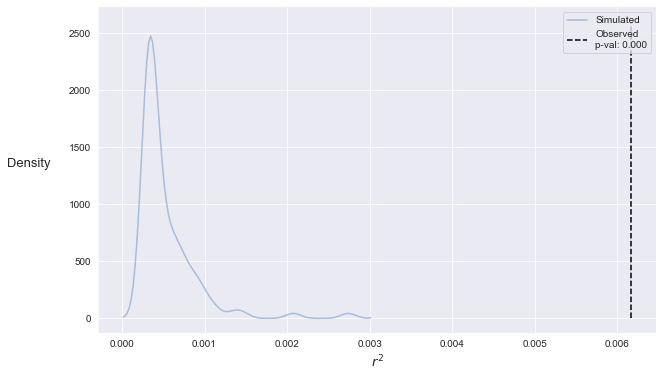

100%|██████████| 100/100 [00:00<00:00, 871.61it/s]

total_travel_distance indep total_travel_time given total_travel_cost:
The p-value of the permutation C.I.T. is 0.00.


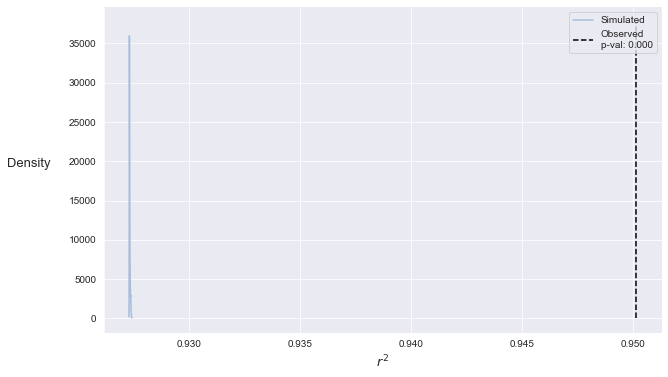

100%|██████████| 100/100 [00:00<00:00, 945.30it/s]

total_travel_distance indep total_travel_time given num_licensed_drivers:
The p-value of the permutation C.I.T. is 0.00.


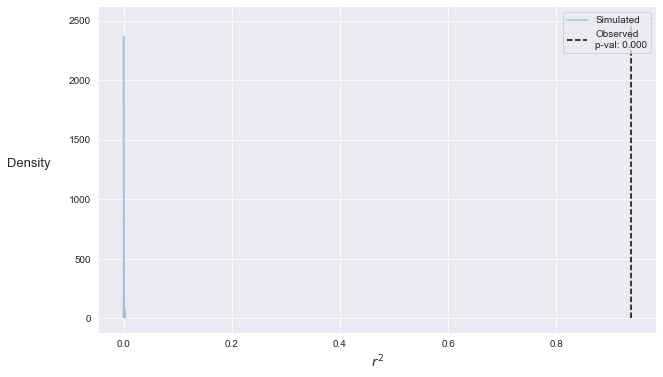

100%|██████████| 100/100 [00:00<00:00, 946.57it/s]

total_travel_distance indep total_travel_time given num_cars:
The p-value of the permutation C.I.T. is 0.00.


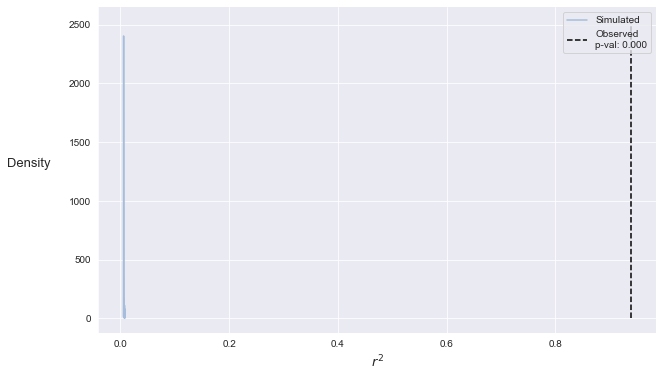

100%|██████████| 100/100 [00:00<00:00, 903.95it/s]

total_travel_distance indep total_travel_cost given total_travel_time:
The p-value of the permutation C.I.T. is 0.00.


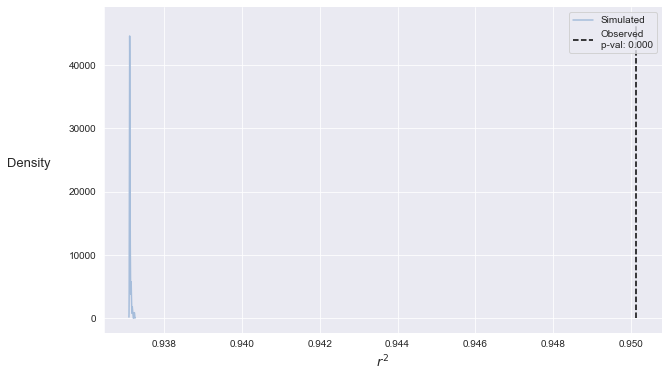

100%|██████████| 100/100 [00:00<00:00, 975.29it/s]

total_travel_distance indep total_travel_cost given num_licensed_drivers:
The p-value of the permutation C.I.T. is 0.00.


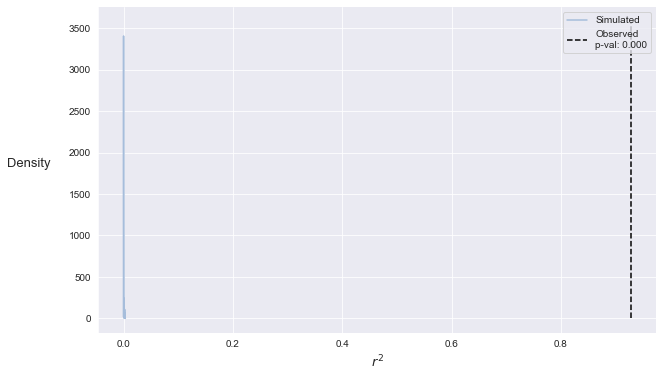

100%|██████████| 100/100 [00:00<00:00, 944.03it/s]

total_travel_distance indep total_travel_cost given num_cars:
The p-value of the permutation C.I.T. is 0.00.


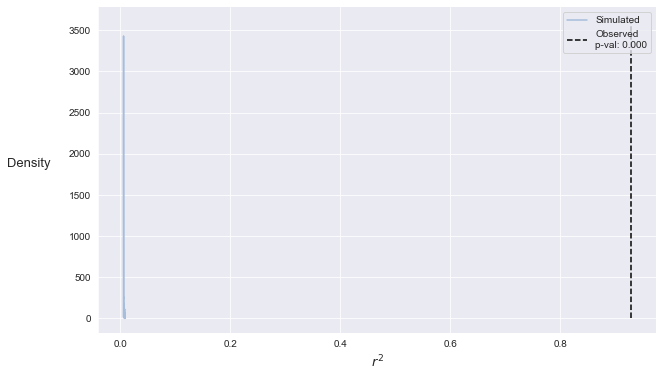

100%|██████████| 100/100 [00:00<00:00, 886.09it/s]

total_travel_distance indep num_licensed_drivers given total_travel_time:
The p-value of the permutation C.I.T. is 0.00.


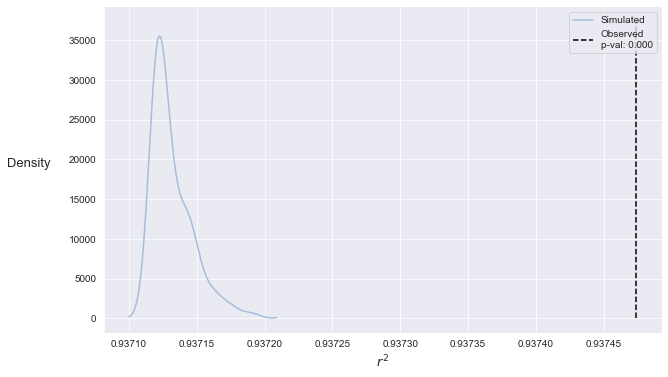

100%|██████████| 100/100 [00:00<00:00, 966.77it/s]

total_travel_distance indep num_licensed_drivers given total_travel_cost:
The p-value of the permutation C.I.T. is 0.00.


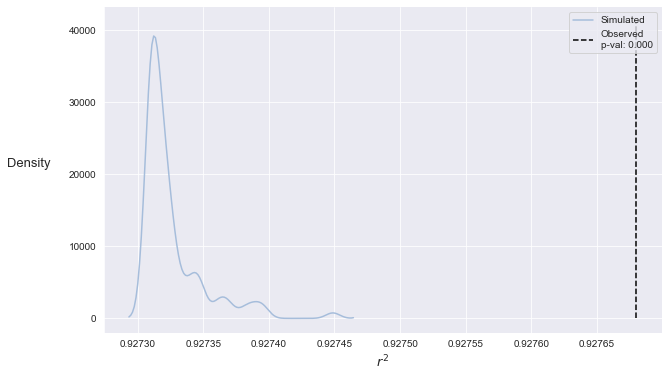

100%|██████████| 100/100 [00:00<00:00, 969.57it/s]

total_travel_distance indep num_licensed_drivers given num_cars:
The p-value of the permutation C.I.T. is 0.00.


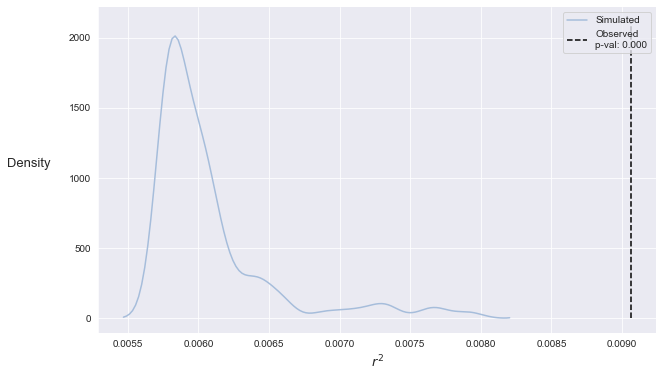

100%|██████████| 100/100 [00:00<00:00, 930.24it/s]

total_travel_distance indep num_cars given total_travel_time:
The p-value of the permutation C.I.T. is 0.00.


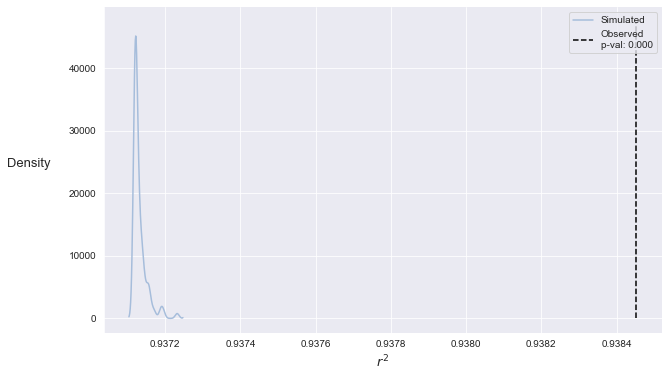

100%|██████████| 100/100 [00:00<00:00, 959.56it/s]

total_travel_distance indep num_cars given total_travel_cost:
The p-value of the permutation C.I.T. is 0.00.


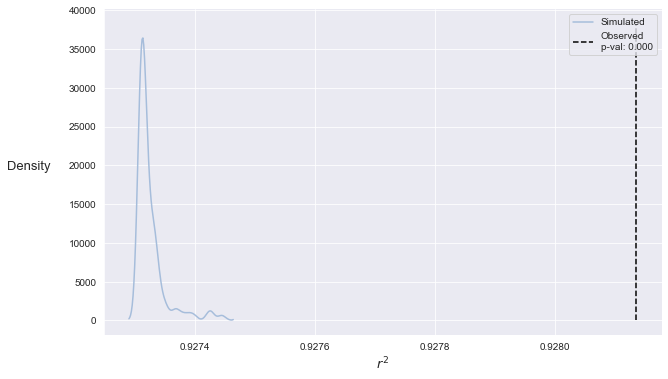

100%|██████████| 100/100 [00:00<00:00, 976.83it/s]

total_travel_distance indep num_cars given num_licensed_drivers:
The p-value of the permutation C.I.T. is 0.00.


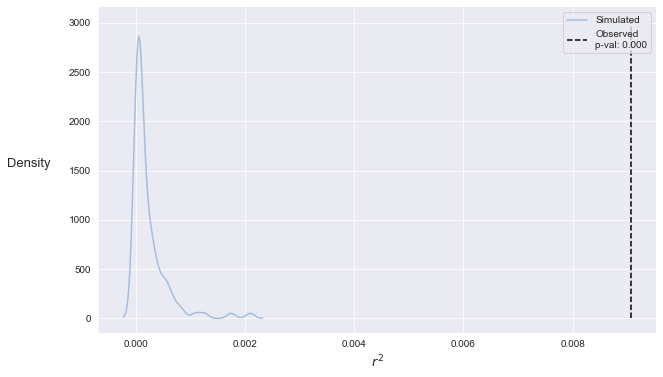

100%|██████████| 100/100 [00:00<00:00, 932.71it/s]

num_licensed_drivers indep total_travel_time given total_travel_cost:
The p-value of the permutation C.I.T. is 0.98.


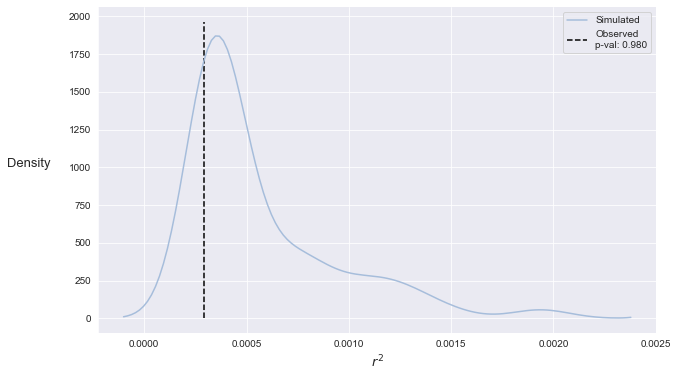

100%|██████████| 100/100 [00:00<00:00, 967.20it/s]

num_licensed_drivers indep total_travel_time given total_travel_distance:
The p-value of the permutation C.I.T. is 0.00.


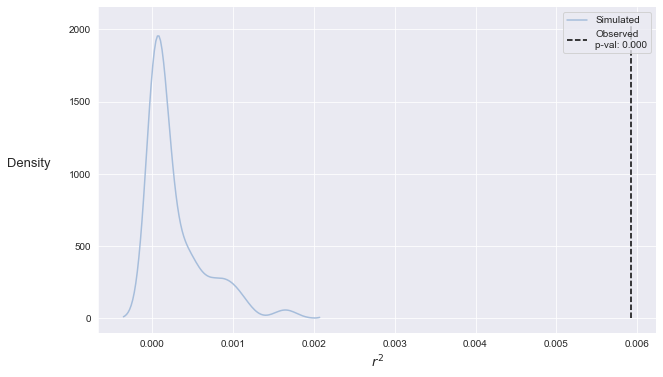

100%|██████████| 100/100 [00:00<00:00, 942.03it/s]

num_licensed_drivers indep total_travel_time given num_cars:
The p-value of the permutation C.I.T. is 0.00.


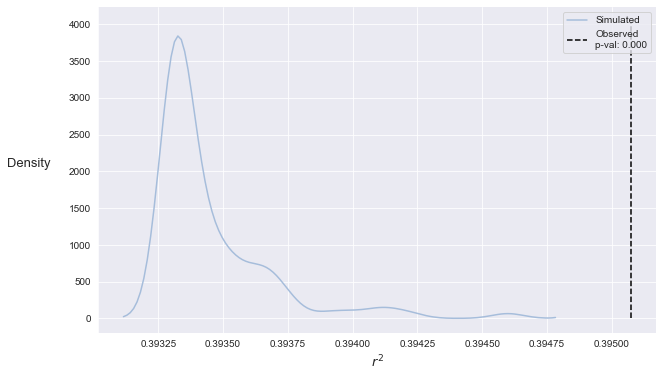

100%|██████████| 100/100 [00:00<00:00, 955.28it/s]

num_licensed_drivers indep total_travel_cost given total_travel_time:
The p-value of the permutation C.I.T. is 0.79.


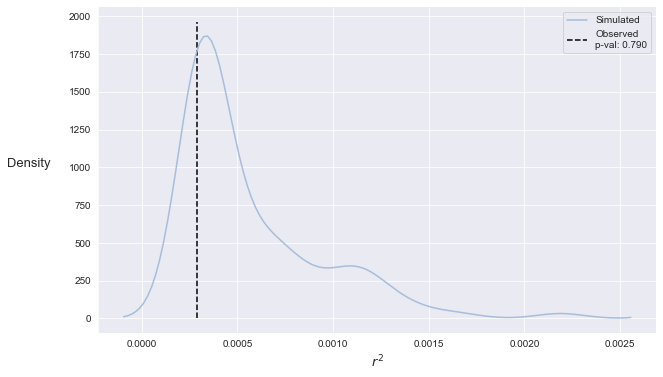

100%|██████████| 100/100 [00:00<00:00, 960.25it/s]

num_licensed_drivers indep total_travel_cost given total_travel_distance:
The p-value of the permutation C.I.T. is 0.00.


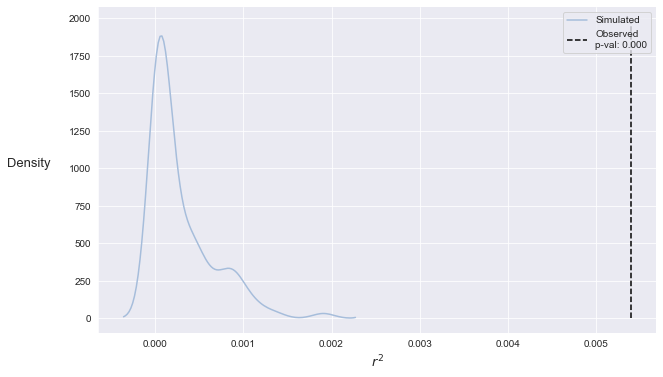

100%|██████████| 100/100 [00:00<00:00, 974.66it/s]

num_licensed_drivers indep total_travel_cost given num_cars:
The p-value of the permutation C.I.T. is 0.00.


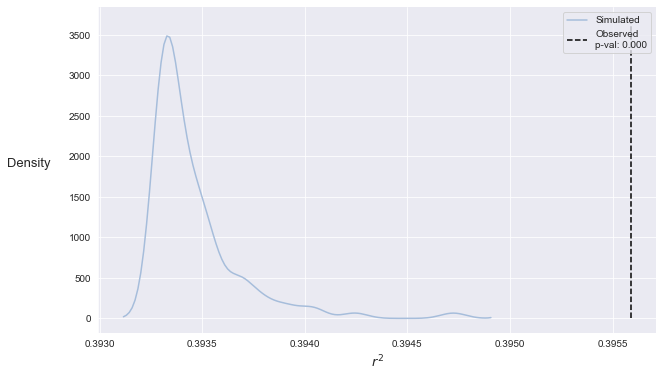

100%|██████████| 100/100 [00:00<00:00, 902.42it/s]

num_licensed_drivers indep total_travel_distance given total_travel_time:
The p-value of the permutation C.I.T. is 0.00.


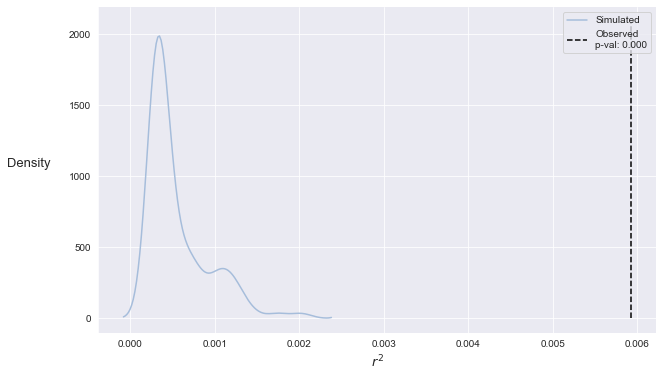

100%|██████████| 100/100 [00:00<00:00, 937.98it/s]

num_licensed_drivers indep total_travel_distance given total_travel_cost:
The p-value of the permutation C.I.T. is 0.00.


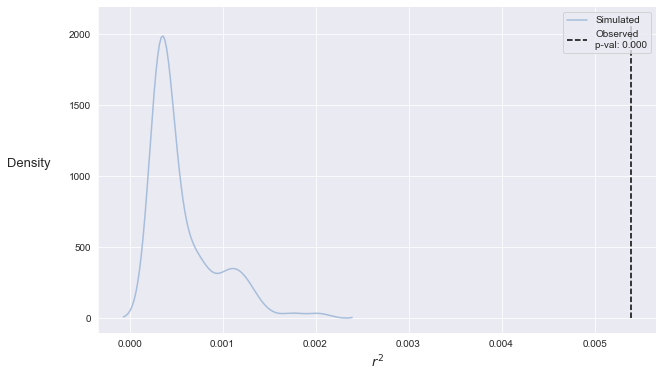

100%|██████████| 100/100 [00:00<00:00, 1006.58it/s]

num_licensed_drivers indep total_travel_distance given num_cars:
The p-value of the permutation C.I.T. is 0.00.


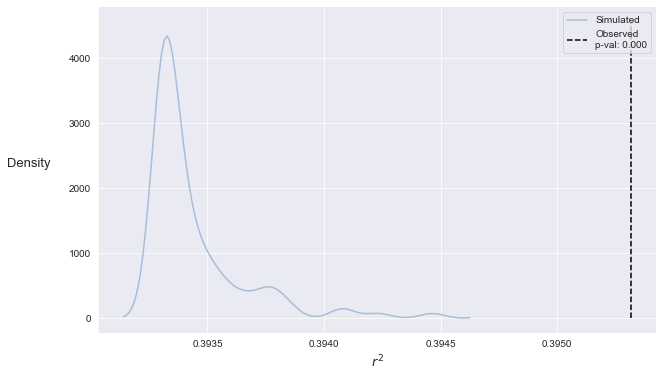

100%|██████████| 100/100 [00:00<00:00, 991.53it/s]

num_licensed_drivers indep num_cars given total_travel_time:
The p-value of the permutation C.I.T. is 0.00.


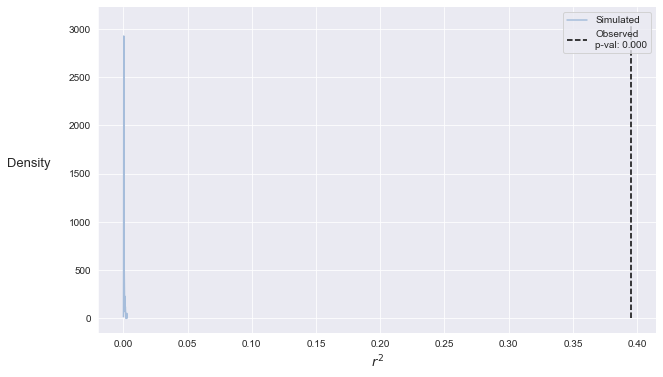

100%|██████████| 100/100 [00:00<00:00, 939.21it/s]

num_licensed_drivers indep num_cars given total_travel_cost:
The p-value of the permutation C.I.T. is 0.00.


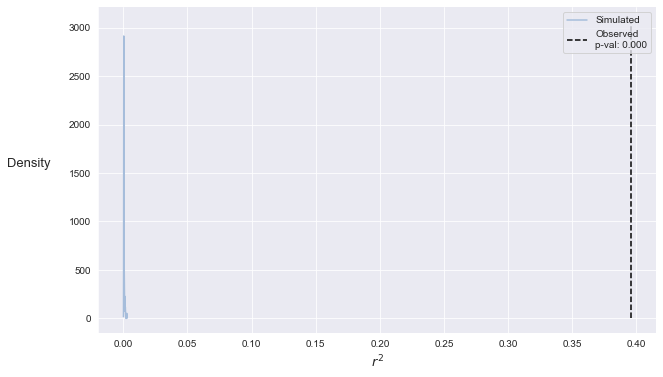

100%|██████████| 100/100 [00:00<00:00, 978.76it/s]

num_licensed_drivers indep num_cars given total_travel_distance:
The p-value of the permutation C.I.T. is 0.00.


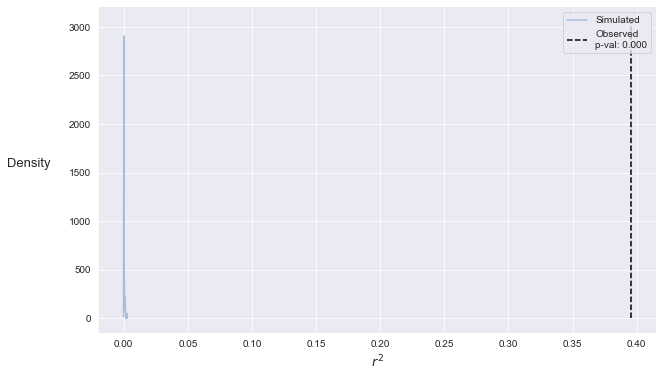

100%|██████████| 100/100 [00:00<00:00, 968.01it/s]

num_cars indep total_travel_time given total_travel_cost:
The p-value of the permutation C.I.T. is 0.16.


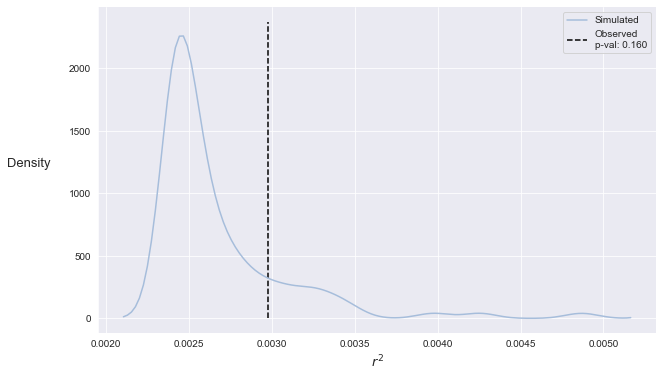

100%|██████████| 100/100 [00:00<00:00, 1024.58it/s]

num_cars indep total_travel_time given total_travel_distance:
The p-value of the permutation C.I.T. is 0.00.


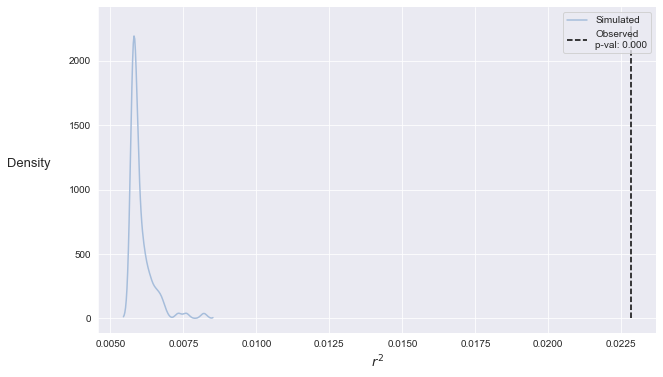

100%|██████████| 100/100 [00:00<00:00, 976.11it/s]

num_cars indep total_travel_time given num_licensed_drivers:
The p-value of the permutation C.I.T. is 0.00.


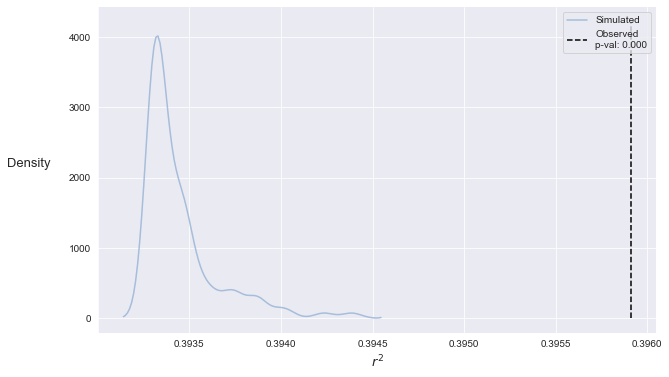

100%|██████████| 100/100 [00:00<00:00, 941.69it/s]

num_cars indep total_travel_cost given total_travel_time:
The p-value of the permutation C.I.T. is 0.03.


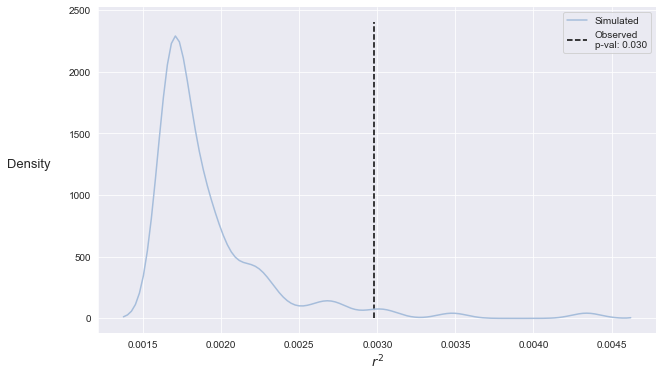

100%|██████████| 100/100 [00:00<00:00, 961.91it/s]

num_cars indep total_travel_cost given total_travel_distance:
The p-value of the permutation C.I.T. is 0.00.


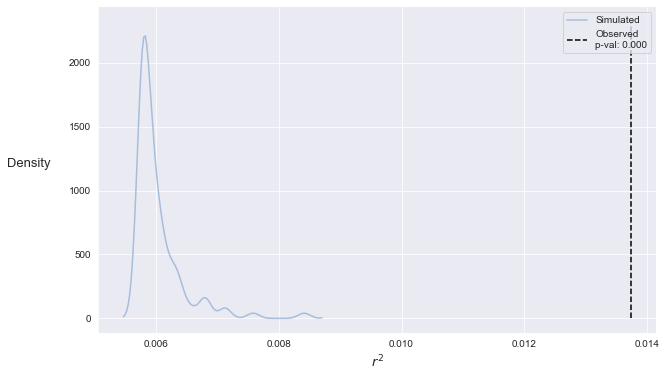

100%|██████████| 100/100 [00:00<00:00, 975.51it/s]

num_cars indep total_travel_cost given num_licensed_drivers:
The p-value of the permutation C.I.T. is 0.00.


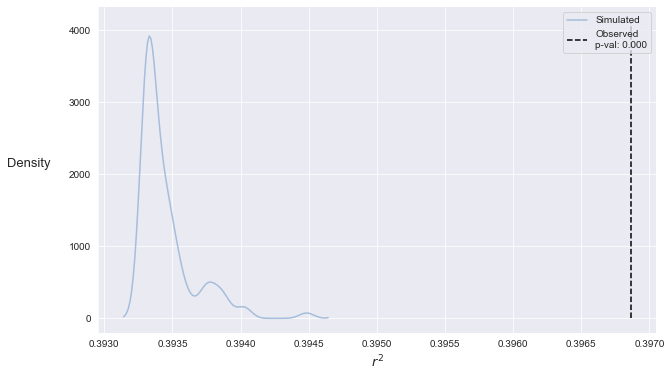

100%|██████████| 100/100 [00:00<00:00, 977.40it/s]

num_cars indep total_travel_distance given total_travel_time:
The p-value of the permutation C.I.T. is 0.00.


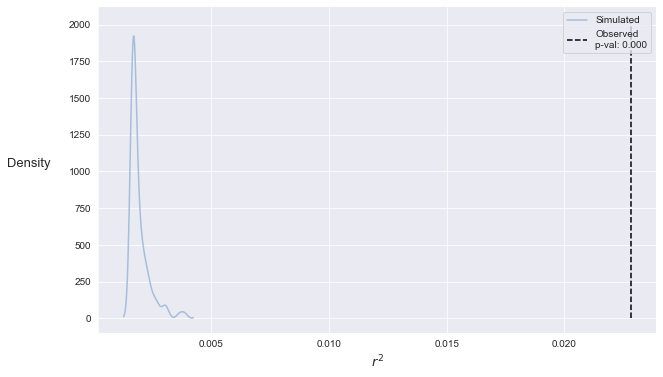

100%|██████████| 100/100 [00:00<00:00, 989.49it/s]

num_cars indep total_travel_distance given total_travel_cost:
The p-value of the permutation C.I.T. is 0.00.


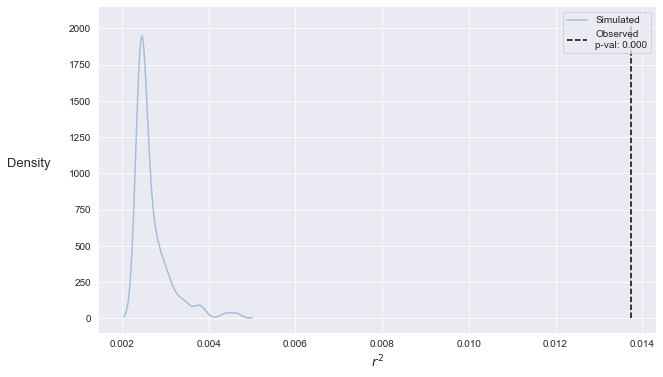

100%|██████████| 100/100 [00:00<00:00, 1024.38it/s]

num_cars indep total_travel_distance given num_licensed_drivers:
The p-value of the permutation C.I.T. is 0.00.


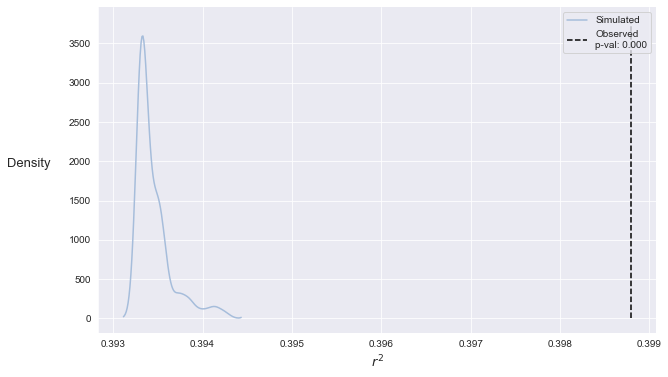

100%|██████████| 100/100 [00:00<00:00, 1005.82it/s]

num_cars indep num_licensed_drivers given total_travel_time:
The p-value of the permutation C.I.T. is 0.00.


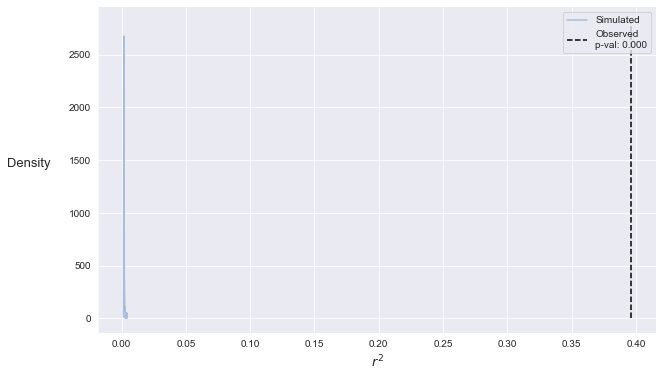

100%|██████████| 100/100 [00:00<00:00, 964.67it/s]

num_cars indep num_licensed_drivers given total_travel_cost:
The p-value of the permutation C.I.T. is 0.00.


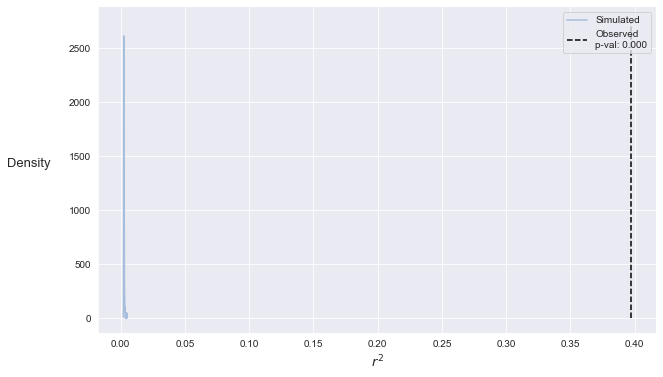

100%|██████████| 100/100 [00:00<00:00, 938.13it/s]

num_cars indep num_licensed_drivers given total_travel_distance:
The p-value of the permutation C.I.T. is 0.00.


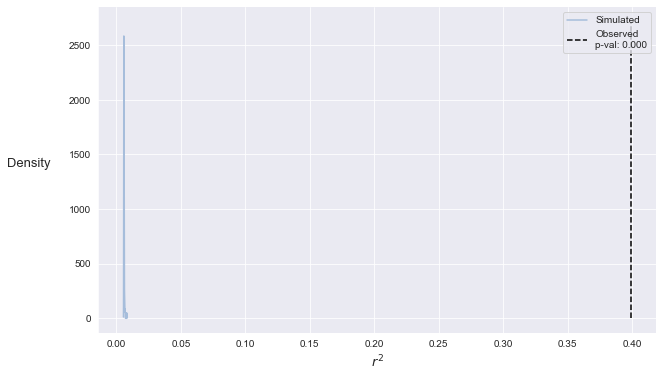

In [7]:
# Test the conditional independencies of all triplets of variables
for col_1, col_2, col_3 in triplets:
    col_1_array = drive_alone_df[col_1].values
    col_2_array = drive_alone_df[col_2].values
    col_3_array = drive_alone_df[col_3].values
    
    print('{} indep {} given {}:'.format(col_1, col_2, col_3))
    oi.visual_permutation_test(
        col_1_array,
        col_2_array,
        z_array=col_3_array,
        num_permutations=NUM_PERMUTATIONS,
        permutation_color=PERMUTED_COLOR)

## Findings
Based on the conditional independence tests, I should investigate the joint distributions between:
- total_travel_time indep num_licensed_drivers given total_travel_cost
- **total_travel_time indep num_cars given total_travel_cost**
- total_travel_cost indep num_licensed_drivers given total_travel_time
- num_licensed_drivers indep total_travel_time given total_travel_cost
- num_licensed_drivers indep total_travel_cost given total_travel_time
- **num_cars indep total_travel_time given total_travel_cost**

However, from the marginal independence tests, we are already assuming that `num_licensed_drivers` is marginally independent of travel time, cost, and distance.

Accordingly, we would only now need to investigate `num_cars` being conditionally independent of travel time given travel cost.

Let's make this assumption and proceed. I'll check the assumption afterwards.

## Step 5: Update working graph

## Step 6: Test all "2nd-order" interactions.
In other look for conditional independencies once controlling for two variables.

In [8]:
def computed_vs_obs_r2_order_2(
    x1_array: np.ndarray,
    x2_array: np.ndarray,
    z_array: Optional[np.ndarray]=None,
    seed: Optional[int]=None,
    num_permutations: int=100,
    progress: bool=True) -> Tuple[float, np.ndarray]:
    """
    Using sklearn's default LinearRegression regressor to predict `x1_array`
    given `x2_array` (and optionally, `z_array`), this function computes
    r2 using the observed `x2_array` and permuted versions of `x2_array`.

    Parameters
    ----------
    x1_array : 1D np.ndarray.
        Denotes the target variable to be predicted.
    x2_array : 1D np.ndarray.
        Denotes the explanatory variable to be used and permuted when trying to
        predict `x1_array`.
    z_array : optional, 1D ndarray or None.
        Detnoes an explanatory variable to be conditioned on, but not to be
        permuted when predicting `x1_array`. Default == None.
    seed : optional, positive int or None.
        Denotes the random seed to be used when permuting `x2_array`.
        Default == None.
    num_permutations : optional, positive int.
        Denotes the number of permutations to use when predicting `x1_array`.
        Default == 100.
    progress : optional, bool.
        Denotes whether or not a tqdm progress bar should be displayed as this
        function is run. Default == True.

    Returns
    -------
    obs_r2 : float
        Denotes the r2 value obtained using `x2_array` to predict `x1_array`,
        given `z_array` if it was not None.
    permuted_r2 : 1D np.ndarray
        Should have length `num_permutations`. Each element denotes the r2
        attained using a permuted version of `x2_array` to predict `x1_array`,
        given `z_array` if it was not None.
    """
    # Set a random seed for reproducibility
    if seed is not None:
        np.random.seed(seed)

    # Determine how to create the predictors for the permutation test, based
    # on whether we want a marginal independence test (i.e. z_array = None)
    # or a conditional independence test (isinstance(z_array, np.ndarray))
    def create_predictors(array_2):
        if z_array is None:
            return oi._create_predictors((array_2,))
        return oi._create_predictors((array_2, z_array[:, 0], z_array[:, 1]))

    # Combine the various predictors
    combined_obs_predictors = create_predictors(x2_array)

    # Determine the number of rows being plotted
    num_rows = x1_array.shape[0]

    # Create a regressor to be used to compute the conditional expectations
    regressor = oi._make_regressor(combined_obs_predictors, x1_array)

    # Get the observed expectations
    obs_expectation = regressor.predict(combined_obs_predictors)
    obs_r2 = oi.r2_score(x1_array, obs_expectation)

    # Initialize arrays to store the permuted expectations and r2's
    permuted_expectations = np.empty((num_rows, num_permutations))
    permuted_r2 = np.empty(num_permutations, dtype=float)

    # Get the permuted expectations
    shuffled_index_array = np.arange(num_rows)

    iterable = range(num_permutations)
    if progress:
        iterable = oi.tqdm(iterable)

    for i in iterable:
        # Shuffle the index array
        np.random.shuffle(shuffled_index_array)
        # Get the new set of permuted X_2 values
        current_x2 = x2_array[shuffled_index_array]
        # Get the current combined predictors
        current_predictors = create_predictors(current_x2)
        # Fit a new model and store the current expectation
        current_regressor =\
            oi._make_regressor(current_predictors, x1_array)
        permuted_expectations[:, i] =\
            current_regressor.predict(current_predictors)
        permuted_r2[i] = oi.r2_score(x1_array, permuted_expectations[:, i])
    return obs_r2, permuted_r2

100%|██████████| 100/100 [00:00<00:00, 806.73it/s]


The p-value of the permutation C.I.T. is 0.04.


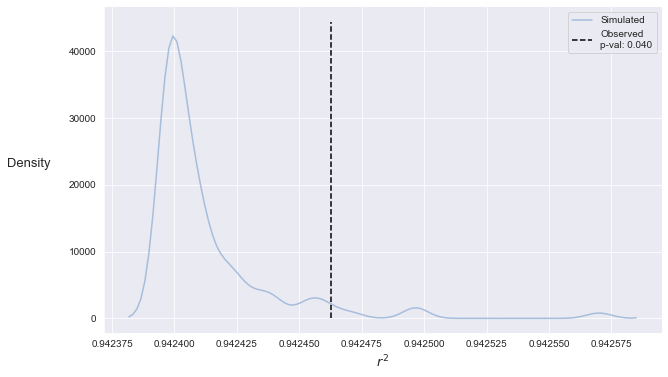

0.04

In [9]:
# Test case: x=cost, y=num_cars, z={time, distance}
cost_array = drive_alone_df[COST_COLUMN].values
num_car_array = drive_alone_df[NUM_AUTOS_COLUMN].values
test_z_array = drive_alone_df[[TIME_COLUMN, DISTANCE_COLUMN]].values

test_obs_r2, test_permuted_r2 =\
    computed_vs_obs_r2_order_2(cost_array, num_car_array, test_z_array)

oi.visualize_permutation_results(test_obs_r2, test_permuted_r2)

100%|██████████| 100/100 [00:00<00:00, 870.94it/s]


The p-value of the permutation C.I.T. is 0.00.


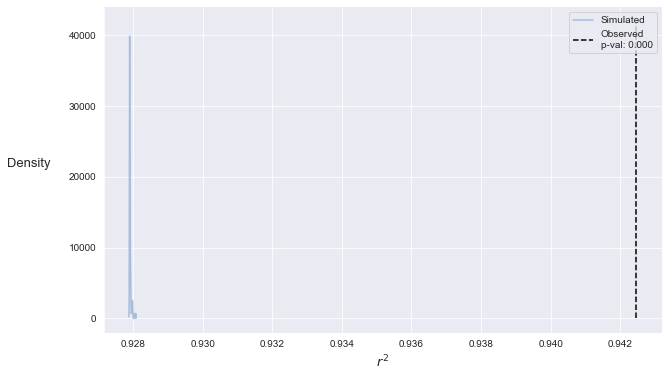

0.0

In [10]:
# Test case: x=cost, y=time, z={num_cars, distance}
cost_array = drive_alone_df[COST_COLUMN].values
time_array = drive_alone_df[TIME_COLUMN].values
test_z_array = drive_alone_df[[NUM_AUTOS_COLUMN, DISTANCE_COLUMN]].values

test_obs_r2, test_permuted_r2 =\
    computed_vs_obs_r2_order_2(cost_array, time_array, test_z_array)

oi.visualize_permutation_results(test_obs_r2, test_permuted_r2)

100%|██████████| 100/100 [00:00<00:00, 853.85it/s]


The p-value of the permutation C.I.T. is 0.00.


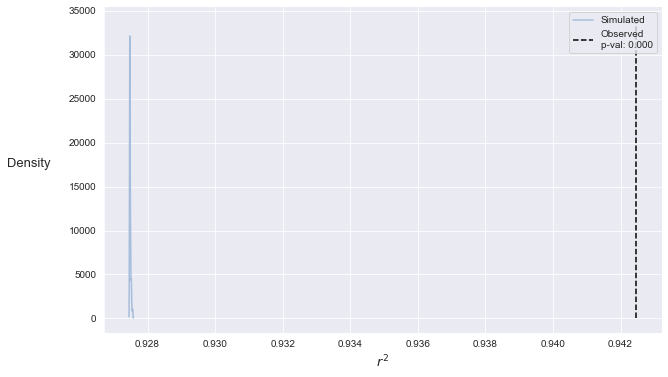

0.0

In [11]:
# Test case: x=cost, y=distance, z={num_cars, time}
cost_array = drive_alone_df[COST_COLUMN].values
distance_array = drive_alone_df[DISTANCE_COLUMN].values
test_z_array = drive_alone_df[[NUM_AUTOS_COLUMN, TIME_COLUMN]].values

test_obs_r2, test_permuted_r2 =\
    computed_vs_obs_r2_order_2(cost_array, distance_array, test_z_array)

oi.visualize_permutation_results(test_obs_r2, test_permuted_r2)

100%|██████████| 100/100 [00:00<00:00, 841.57it/s]


The p-value of the permutation C.I.T. is 0.00.


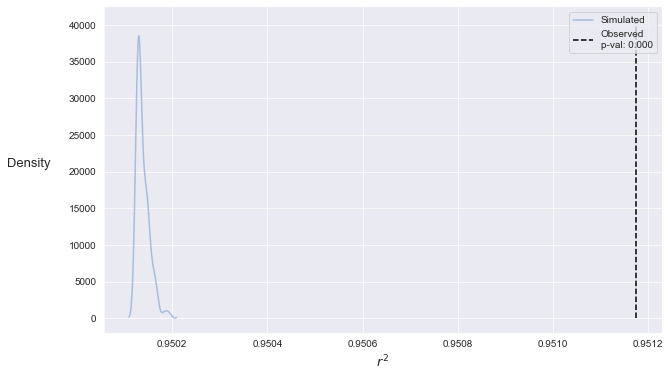

0.0

In [12]:
# Test case: x=distance, y=num_cars, z={time, cost}
distance_array = drive_alone_df[DISTANCE_COLUMN].values
num_cars_array = drive_alone_df[NUM_AUTOS_COLUMN].values
test_z_array = drive_alone_df[[TIME_COLUMN, COST_COLUMN]].values

test_obs_r2, test_permuted_r2 =\
    computed_vs_obs_r2_order_2(distance_array, num_cars_array, test_z_array)

oi.visualize_permutation_results(test_obs_r2, test_permuted_r2)

100%|██████████| 100/100 [00:00<00:00, 799.24it/s]


The p-value of the permutation C.I.T. is 0.00.


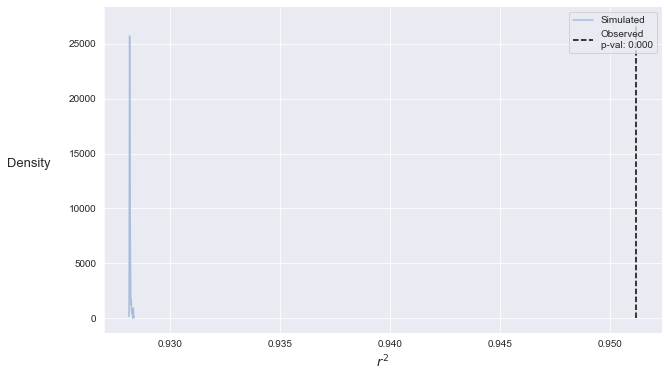

0.0

In [13]:
# Test case: x=distance, y=time, z={num_cars, cost}
distance_array = drive_alone_df[DISTANCE_COLUMN].values
time_array = drive_alone_df[TIME_COLUMN].values
test_z_array = drive_alone_df[[NUM_AUTOS_COLUMN, COST_COLUMN]].values

test_obs_r2, test_permuted_r2 =\
    computed_vs_obs_r2_order_2(distance_array, time_array, test_z_array)

oi.visualize_permutation_results(test_obs_r2, test_permuted_r2)

100%|██████████| 100/100 [00:00<00:00, 829.77it/s]


The p-value of the permutation C.I.T. is 0.06.


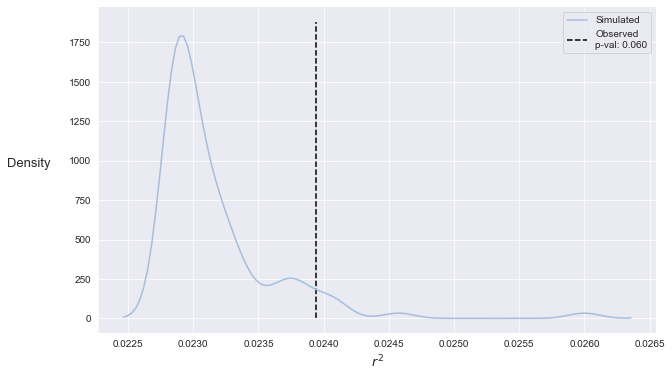

0.06

In [14]:
# Test case: x=num_cars, y=cost, z={time, distance}
cost_array = drive_alone_df[COST_COLUMN].values
num_car_array = drive_alone_df[NUM_AUTOS_COLUMN].values
test_z_array = drive_alone_df[[TIME_COLUMN, DISTANCE_COLUMN]].values

test_obs_r2, test_permuted_r2 =\
    computed_vs_obs_r2_order_2(num_car_array, cost_array, test_z_array)

oi.visualize_permutation_results(test_obs_r2, test_permuted_r2)

### Findings
Based on the "second-order" conditional independence tests, the only edges that are plausible to exclude is the edge between cost and number of automobiles per household.

The probability of those variables being conditionally independent given travel distance and travel time is low, but let's go with it for the moment.

The result of followig the PC Algorithm to its conclusion, assuming that the algorithms conclusions are met, is a "faithful indistinguishability class" where:
- `num_licensed_drivers` $\rightarrow$ `num_cars` $\leftarrow$ `total_travel_distance`
- `total_travel_distance` -- `total_travel_cost` -- `total_travel_time`
- `total_travel_distance` -- `total_travel_time`

The directionality of relationships between time, cost, and distance are not given.

Based on the computational data generating process though (i.e. the use of travel skims to construct the data and how the travel skims were constructed), we know that:
- `total_travel_distance` $\rightarrow$ `total_travel_cost`
- `total_travel_distance` $\rightarrow$ `total_travel_time`

This leaves the final set of relations as
- `num_licensed_drivers` $\rightarrow$ `num_cars` $\leftarrow$ `total_travel_distance`
- `total_travel_time` $\leftarrow$ `total_travel_distance` $\rightarrow$ `total_travel_cost`
- `total_travel_cost` -- `total_travel_time`